# [E-10] CIFAR-10 이미지 생성하기

### 달라지는 점
- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다.   
생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

## STEP 1. 작업환경 구성하기
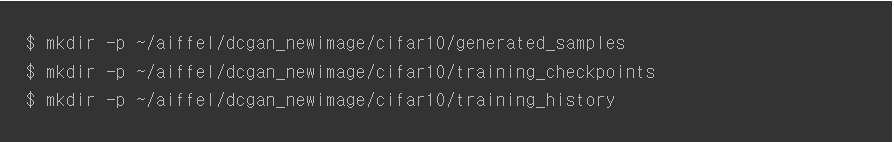

In [1]:
# 필요한 라이브러리 불러오기
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

## ****STEP 2. 데이터셋 구성하기****

---

**1. CIFAR-10 데이터셋도 `tf.keras` 안에 있는 `datasets`에서 가져오기**


**2. 로드한 학습 데이터를 시각화를 통해 확인**  

**3. 학습에 사용할 train_x의 이미지를 -1, 1로 정규화**

**4. tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해보기**

### 2.1 CIFAR-10 데이터셋 가져오기

In [2]:
# CIFAR-10 데이터셋 가져오기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

### 2.2 데이터를 시각화를 통해 확인

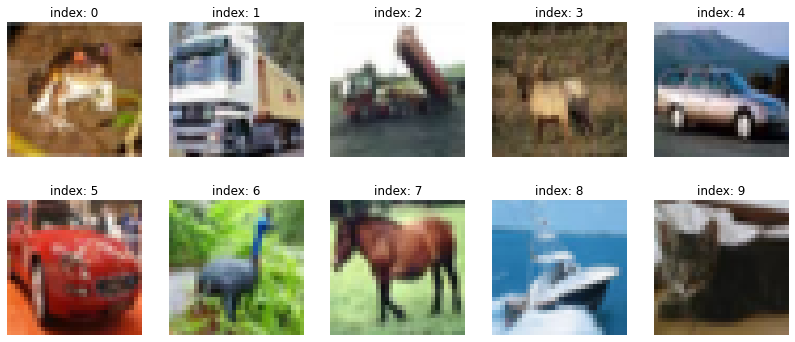

In [3]:
# 열 개의 이미지 보기
plt.figure(figsize=(14, 6))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

### 2.3 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

In [4]:
# 픽셀을 -1, 1로 정규화 → 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나누기
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


### 2.4 tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해보기

In [5]:
# 버퍼사이즈, 배치사이즈 정의
BUFFER_SIZE = 100000
BATCH_SIZE = 256

# 텐서플로우의 Dataset 으로 훈련ds 만들기
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **STEP 3. 생성자 모델 구현하기**

---

1. **(32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성**
2. **noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성**
3. **생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인**

### 3.1 Generator model 구현



In [6]:
# make_generator_model함수 만들기
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

### 3.1 .1생성자 모델 생성, 모델 구조 보기

In [7]:
# generator 모델 생성, 모델 세부 내용인 summary를 출력
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### 3.2  노이즈 벡터 생성
**shape=(1, 100)의 형상을 가지는 가우시안 분포에서 뽑아낸 랜덤 노이즈 벡터를 생성**

**[1, 32, 32, 3] 사이즈의 이미지가 생성**
- **첫 번째 1은 1개(batch_size=1)라는 뜻, (32, 32, 3) 사이즈 이미지가 생성**

In [8]:
# tf.random.normal을 이용하여 가우시안 분포(범위 1~100)에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 만들기
noise = tf.random.normal([1, 100])

# 노이즈 벡터의 출력보기
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

### 3.3 노이즈 이미지  시각화

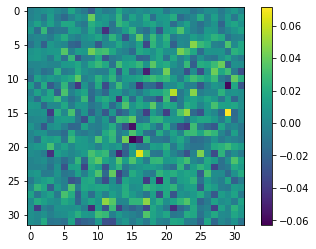

In [9]:
# 노이즈 이미지  시각화
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP 4. 판별자 모델 구현하기

1. **(32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성**
2. **위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인**

### 4.1 판별자 모델 설계

**판별자를 설계**

- **Conv2D 층으로 이미지의 크기 줄이기**
- **첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄이기**
- **Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=6272, 즉 (1, 6272) 형상의 벡터로 변환**
- **생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할**
- **1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력**

In [10]:
# 판별자를 모델 설계
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

### 4.1.1 판별자 모델 생성, 모델 구조 확인

In [11]:
# discriminator라는 판별자 모델 생성, 모델 세부 내용인 summary를 출력
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

### 4.2 가짜 이미지 판별값 확인

In [12]:
# 가짜 이미지를 판별자에 입력 후 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00020553]], dtype=float32)>

****STEP 5. 손실함수와 최적화 함수 구현하기****

---

- **생성자와 판별자의 손실함수(loss)를 구현**
- **판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현**
- **생성자와 판별자를 최적화하는 optimizer를 정의**

## Step 5. 손실함수와 최적화 함수

1. 손실함수(loss function)
2. 최적화 함수(optimizer)

### 5.1 **손실함수(loss function)**

---

- **GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용**
- **점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 사용**
- **판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제이므로 
이진 교차 엔트로피(binary cross entropy)를 사용**
- **tf.keras.losses 라이브러리 안에 존재**
<br>

### **tf.keras.losses의 BinaryCrossEntropy 클래스**
---

- **들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정** 🎁 **([참고](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy#args_1))**
- **from_logits를 True로 설정**
    - **BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 계산**

### 5.1.1 cross_entropy 정의

In [13]:
# 0~1 사이의 값으로 정규화
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 5.1.2 fake_output과 real_output을 각각 1 또는 0에 비교를 하는 예시

**cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output 두 가지를 활용**

- **fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)**
- **real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)**

<br>

**fake_output과 real_output을 각각 1 또는 0에 비교를 하는 법**

- **tf.ones_like()와 tf.zeros_like() 함수를 활용**
    - **특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용**

In [14]:
# 특정 벡터와 동일한 크기이면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 때 사용
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

### 5.1.3 **generator_loss**

---


**fake_output이 1에 가까워지기를 바라므로**

**tf.ones_like와의 교차 엔트로피값을 계산하면  
cross_entropy(tf.ones_like(fake_output), fake_output)) 출력값은   
fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값 보유**

In [15]:
# generator_loss 구현
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 5.1.4 **discriminator_loss**

---

**real_output값은 1에 가까워지기를,  fake_output값은 0에 가까워지기를 바라므로,** 

- **두 가지 loss값을 모두 계산**
    - **real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교**
- **최종 discriminator_loss 값은 이 둘을 더한 값**

In [16]:
# discriminator_loss 구현
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### **5.1.5 discriminator accuracy**

---

**판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산**

- **GAN의 학습에서 매우 중요**
- **두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용**

**판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까??**

- **accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적**
- **fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다**

<br><br>
**함수 안에 사용된 tensorflow 함수들의 역할을 순차적으로 예를 들어 정리**

**ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,**

- **(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별**
   - **tf.Tensor([False, False, True,True])**
- **(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 -   
tf.Tensor([0.0, 0.0, 1.0, 1.0])**
- **(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - 0.5**

In [17]:
# discriminator accuracy 함수 구현
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### **5.2 최적화 함수(optimizer)**

---

**Adam 최적화 기법 을 활용**

- **[문과생도 이해하는 딥러닝 (8) - 신경망 학습 최적화](https://sacko.tistory.com/42)**

- **Adam 함수 또한 `tf.keras.optimizers` 안에 존재**
- **"learning rate"는 0.0001로 설정**
- **중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점**

In [18]:
# optimizer 구현
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인**

- **샘플은 한 번에 16장을 생성**
- **생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈**
- **100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터 만들기**

In [19]:
# 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터 만들기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기

---

**1. 1개 미니배치의 훈련 과정을 처리하는 train_step()함수를 구현**  
**2. 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images()함수를 구현**  
**3. 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로   
    시각화하는 draw_train_history()함수를 구현**  
**4. training_checkpoints디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정 해보기**

### **6.1 하나의 미니 배치 당 진행할 train_step함수 만들기**

- **학습시킬 훈련 함수 위에 @tf.function이라는 데코레이터를 붙여서 사용**  

<br>

**6.1.1 train_step함수 살펴보기**

---

**(1) 입력 데이터: Real Image 역할을 할 images한 세트를 입력으로 받음**

**(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images한 세트와 같은 크기인 BATCH_SIZE만큼 생성함**

**(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with구문 열기**

**(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images생성**

**(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output출력**

**(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산**

**(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산**

**(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산**

**(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신**

**(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴**

In [20]:
# train_step 함수 만들기
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### **6.2 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기**

- **만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인**

**subplot을 이용해서 총 16개의 sample을 시각화하는 과정**

- **16개이므로 4행 4열로 나누어 subplot(4, 4, i+1)로 시각화**
- **plt에 저장되어 보이는 이미지를 plt.savefig로 간단히 파일로 저장**
- **-1,1 사이로 정규화 한 데이터셋 원대상태로 되돌리기**

In [21]:
# train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 6.3 시각화하는 함수를 만들기

**train_step()함수가 리턴하는**   

**gen_loss, disc_loss, real_accuracy, fake_accuracy 4가지 값을**   

**history라는 dict 구조에 리스트로 저장하고 있다가 매 epoch마다 시각화하는 함수를 만들기**

In [22]:
# gen_loss, disc_loss, real_accuracy, fake_accuracy 시각화하는 함수를 만들기
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8    # matlab 차트의 기본 크기를 15,8으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### **6.4 정기적으로 모델을 저장하기 위한 checkpoint를 만들기**

- **optimizer와 생성자, 판별자를 모두 넣어 저장**
- **생성자와 판별자가 학습한 모델 가중치를 저장**
- **학습 환경과 학습한 내용을 저장**
- **checkpoint 모델을 저장하기 위해 작업환경 내에 training_checkpoints라는 디렉토리를 사용**

In [23]:
# checkpoint를 만들어서 학습 내용 저장
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### **STEP 7. 학습 과정 진행하기**

---
1. **전체 모델 생성**
2. **100 epoch, 이미지 저장단위 : 10 iter**
3. **학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현**
4. **학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출**

### 7.1 전체 훈련 모델 만들기

In [24]:
# 전체 훈련 모델 만들기
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### 7.2 **모델을 저장하는 간격을 담당하는 save_every와 전체 학습 에포크를 결정하는 EPOCHS 파라미터도 설정**

- **최대한 GPU 환경에서 실습**

In [25]:
# save_every, EPOCHS 파라미터도 설정 & GPU 환경 사용
save_every = 10
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 훈련

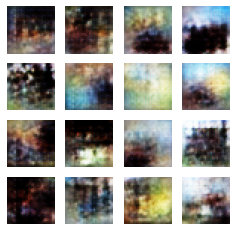

Time for training : 1654 sec


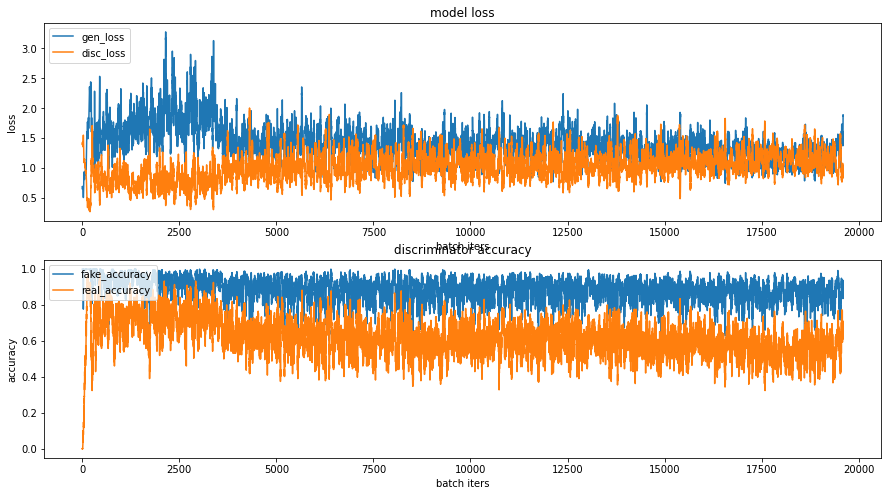

In [26]:
# 훈련
%time
train(train_dataset, EPOCHS, save_every)

### 7.3 **학습과정 시각화하기**

---

**우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들기**

**GIF 파일 : imageio라이브러리를 활용해 만들기 가능**

**imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식**

**코드가 무사히 실행되면, fasion_mnist_dcgan.gif 파일이 저장되어 있는 것을 확인**

In [27]:
# 학습과정 시각화하기 - gif 파일 만들기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1515681 Feb 13 04:23 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


<img alt="cifar" src="https://github.com/flowerJung/flowerJung.github.io/blob/main/image/cifar10_dcgan.gif?raw=true">

- gif파일을 로드하려고 했으나 거듭 실패.. 하지만 성공~~ !!
- 아직 확실한 이미지라고 할 수가 없는 이미지만 있는 듯 하다..
- 다시 시작해야지..

## Step8 GAN 훈련 과정 개선하기


### 1) 첫번째 개선 : epoch=1000, generator_optimizer의 learning_rate=le-3으로 조정

1. checkpoint_dir에 있는 모델을 불러오기
2. epoch, optimizer의 learning_late조정
3. 훈련

### 8.1 checkpoint_dir에 있는 모델을 불러오기

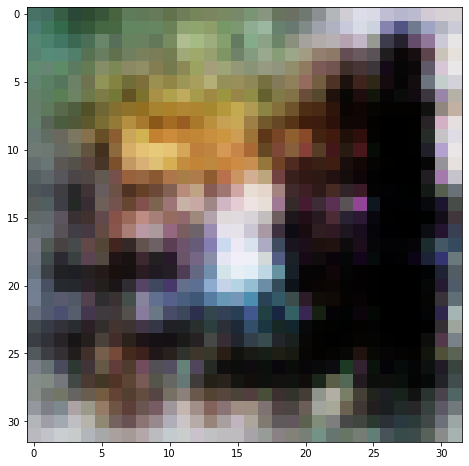

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### 8.2 epoch, optimizer의 learning_late조정

In [29]:
# optimizer 구현
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# epoch 조정
save_every = 50
EPOCHS = 1000

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 8.3 훈련

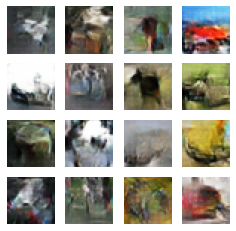

Time for training : 20430 sec


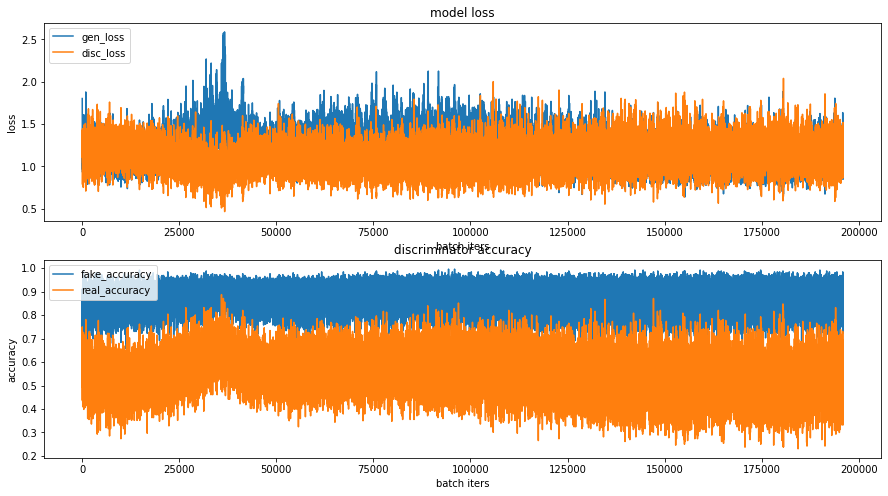

In [30]:
# 훈련
%time
train(train_dataset, EPOCHS, save_every)

### 8.4 저장된 이미지 gif파일 만들기

In [33]:
# 학습과정 시각화하기 - gif 파일 만들기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1000.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1000.gif

-rw-r--r-- 1 root root 4331118 Feb 13 10:07 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1000.gif


<img alt="cifar_1000" src="https://github.com/flowerJung/flowerJung.github.io/blob/main/image/cifar10_dcgan_1000.gif?raw=true">
<img alt="cifar_1000" src="https://github.com/flowerJung/flowerJung.github.io/blob/main/image/cifar10_dcgan_hist_1000.gif?raw=true">


### 전체적인 참고자료를 찾아보고 여러 자료를 검토한 결과 
1. 모델을 확장하는 것은 별로 효과가 없다.
2. optimizer의 learning_rate를 조정하는 것이 좋다고 해서 도전
3. 훈련을 많이 하는 것이 필요하다고 느껴서 도전
4. 레이블을 사용한다면 레이브을 0.9정도 설정하라고 했는 데, 레이블을 사용하지 않으니 패스!

### 훈련결과에 대한 평가
- 100 epoch보다는 훨씬 이미지가 선명한 듯 하다..
- epoch를 1000회 하니 6시간이 걸린다..
- dcgan의 평가는 accuracy가 아니라 인간의 평갈라고 하는 데.. 아직 잘 모르겠다..

### 2. 두번째 도전 - batch_size = 128, epoch=500, generator learning_rate=2e-4
- batch_size가 변경되는 관계로 저장된 파일을 이용하지 않고 처음부터 시작

In [1]:
# 필요한 라이브러리 불러오기
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

### 2.1 CIFAR-10 데이터셋 가져오기

In [2]:
# CIFAR-10 데이터셋 가져오기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

### 2.2 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

In [4]:
# 픽셀을 -1, 1로 정규화 → 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나누기
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


### 2.3 tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해보기

In [5]:
# 버퍼사이즈, 배치사이즈 정의
BUFFER_SIZE = 100000
BATCH_SIZE = 128

# 텐서플로우의 Dataset 으로 훈련ds 만들기
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 3.1 Generator model 구현



In [6]:
# make_generator_model함수 만들기
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

### 3.1 .1생성자 모델 생성, 모델 구조 보기

In [7]:
# generator 모델 생성, 모델 세부 내용인 summary를 출력
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### 4.1 판별자 모델 설계

In [10]:
# 판별자를 모델 설계
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

### 4.1.1 판별자 모델 생성, 모델 구조 확인

In [11]:
# discriminator라는 판별자 모델 생성, 모델 세부 내용인 summary를 출력
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

## 손실함수, 최적화
### 5.1.1 cross_entropy 정의

In [13]:
# 0~1 사이의 값으로 정규화
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 5.1.2 **generator_loss**

In [15]:
# generator_loss 구현
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 5.1.3 **discriminator_loss**

In [16]:
# discriminator_loss 구현
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### **5.1.4 discriminator accuracy**

In [17]:
# discriminator accuracy 함수 구현
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### **5.2 최적화 함수(optimizer)**

In [18]:
# optimizer 구현
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 5.3 노이즈벡터 생성

In [19]:
# 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터 만들기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### **6.1 하나의 미니 배치 당 진행할 train_step함수 만들기**

In [20]:
# train_step 함수 만들기
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### **6.2 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기**

In [21]:
# train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/batch128/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 6.3 시각화하는 함수를 만들기


In [22]:
# gen_loss, disc_loss, real_accuracy, fake_accuracy 시각화하는 함수를 만들기
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10    # matlab 차트의 기본 크기를 15,8으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/batch128/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### **6.4 정기적으로 모델을 저장하기 위한 checkpoint를 만들기**


In [23]:
# checkpoint를 만들어서 학습 내용 저장
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints/batch128'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 7.1 전체 훈련 모델 만들기

In [24]:
# 전체 훈련 모델 만들기
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### 7.2 **모델을 저장하는 간격을 담당하는 save_every와 전체 학습 에포크를 결정하는 EPOCHS 파라미터도 설정**

- **최대한 GPU 환경에서 실습**

In [25]:
# save_every, EPOCHS 파라미터도 설정 & GPU 환경 사용
save_every = 10
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 훈련

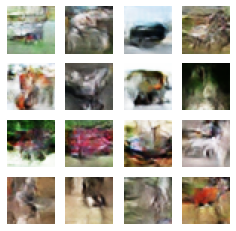

Time for training : 10557 sec


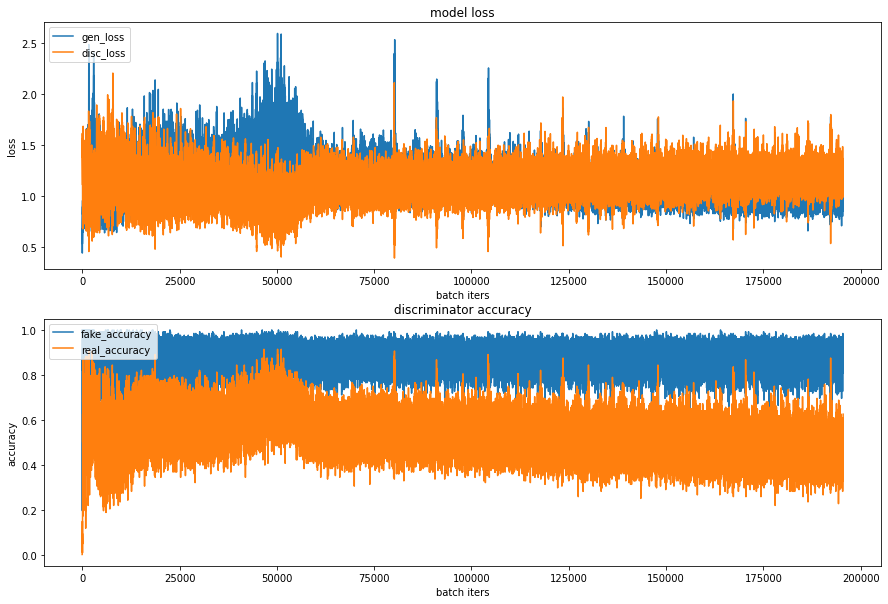

In [26]:
# 훈련
%time
train(train_dataset, EPOCHS, save_every)

### 7.3 **학습과정 시각화하기**

---

**우리가 생성했던 샘플 이미지들을 합쳐 GIF 파일, 일명 움짤로 만들기**

**GIF 파일 : imageio라이브러리를 활용해 만들기 가능**

**imageio.get_writer를 활용해서 파일을 열고, 거기에 append_data로 이미지를 하나씩 붙여나가는 방식**

**코드가 무사히 실행되면, fasion_mnist_dcgan.gif 파일이 저장되어 있는 것을 확인**

In [27]:
# 학습과정 시각화하기 - gif 파일 만들기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_128.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/batch128/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_128.gif

-rw-r--r-- 1 root root 4430648 Feb 14 18:57 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_128.gif


<img alt="cifar_1000" src="https://github.com/flowerJung/flowerJung.github.io/blob/main/image/cifar10_dcgan_128.gif?raw=true">
<img alt="cifar_1000" src="https://github.com/flowerJung/flowerJung.github.io/blob/main/image/cifar10_dcgan_hist128_500.gif?raw=true">

### batch_size=128, epoch=500, learning_rate=2e-4
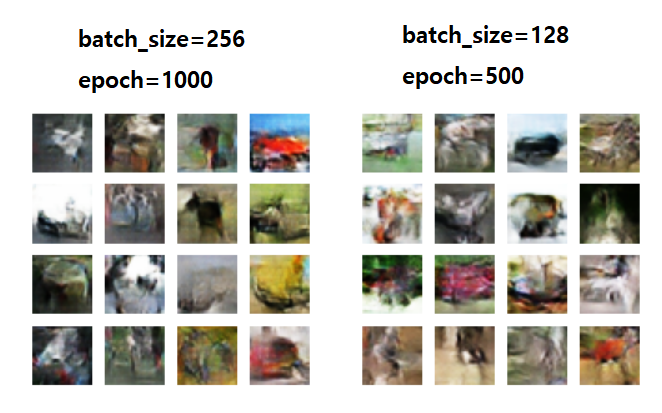
- 아직도 잘 모르겠다..

### 3번째 도전 - epoch=1000, batch_size=128
- 데이터를 저장해야 해서 처음부터 시작

In [1]:
# 필요한 라이브러리 불러오기
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

### 2.1 CIFAR-10 데이터셋 가져오기

In [2]:
# CIFAR-10 데이터셋 가져오기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

### 2.2 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

In [4]:
# 픽셀을 -1, 1로 정규화 → 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나누기
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


### 2.3 tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해보기

In [5]:
# 버퍼사이즈, 배치사이즈 정의
BUFFER_SIZE = 100000
BATCH_SIZE = 128

# 텐서플로우의 Dataset 으로 훈련ds 만들기
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 3.1 Generator model 구현



In [6]:
# make_generator_model함수 만들기
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

### 3.1 .1생성자 모델 생성, 모델 구조 보기

In [7]:
# generator 모델 생성, 모델 세부 내용인 summary를 출력
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### 4.1 판별자 모델 설계


In [10]:
# 판별자를 모델 설계
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

### 4.1.1 판별자 모델 생성, 모델 구조 확인

In [11]:
# discriminator라는 판별자 모델 생성, 모델 세부 내용인 summary를 출력
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

### 5.1 **손실함수(loss function)**

### 5.1.1 cross_entropy 정의

In [13]:
# 0~1 사이의 값으로 정규화
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 5.1.2 **generator_loss**


In [15]:
# generator_loss 구현
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 5.1.3 **discriminator_loss**

In [16]:
# discriminator_loss 구현
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### **5.1.4 discriminator accuracy**


In [17]:
# discriminator accuracy 함수 구현
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### **5.2 최적화 함수(optimizer)**


In [18]:
# optimizer 구현
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 5.3 노이즈 벡터 생성

In [19]:
# 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터 만들기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### **6.1 하나의 미니 배치 당 진행할 train_step함수 만들기**

In [20]:
# train_step 함수 만들기
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### **6.2 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기**

In [21]:
# train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수 만들기
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/batch128_1000/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 6.3 시각화하는 함수를 만들기


In [22]:
# gen_loss, disc_loss, real_accuracy, fake_accuracy 시각화하는 함수를 만들기
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10    # matlab 차트의 기본 크기를 15,10으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/batch128_1000/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### **6.4 정기적으로 모델을 저장하기 위한 checkpoint를 만들기**


In [23]:
# checkpoint를 만들어서 학습 내용 저장
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints/batch128_1000'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### 7.1 전체 훈련 모델 만들기

In [24]:
# 전체 훈련 모델 만들기
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### 7.2 **모델을 저장하는 간격을 담당하는 save_every와 전체 학습 에포크를 결정하는 EPOCHS 파라미터도 설정**

- **최대한 GPU 환경에서 실습**

In [25]:
# save_every, EPOCHS 파라미터도 설정 & GPU 환경 사용
save_every = 20
EPOCHS = 1000

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 훈련

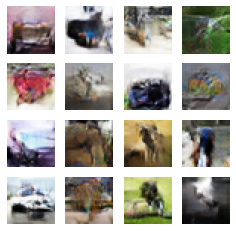

Time for training : 25630 sec


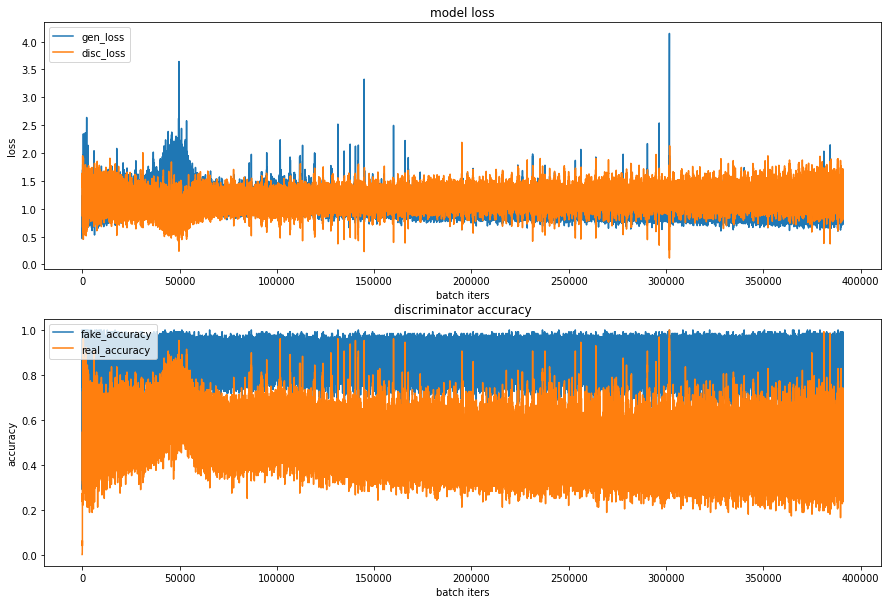

In [26]:
# 훈련
%time
train(train_dataset, EPOCHS, save_every)

### 7.3 **학습과정 시각화하기**

- sample. gif, hist_gif생성

In [27]:
# 학습과정 시각화하기 - gif 파일 만들기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_128_1000.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/batch128_1000/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_128_1000.gif

-rw-r--r-- 1 root root 6045004 Feb 15 09:39 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_128_1000.gif


In [35]:
# 학습과정 시각화하기 - gif 파일 만들기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_hist_1000.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/training_history/*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_hist_1000.gif

-rw-r--r-- 1 root root 3518495 Feb 15 11:09 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_hist_1000.gif


<img alt="cifar128_1000" src="https://github.com/flowerJung/flowerJung.github.io/blob/main/image/cifar10_dcgan_128_1000.gif?raw=true">
<img alt="cifar_1000" src="https://github.com/flowerJung/flowerJung.github.io/blob/main/image/cifar10_dcgan_hist128_1000.gif?raw=true">

### batch_size=128, epoch=1000, learning_rate=2e-4
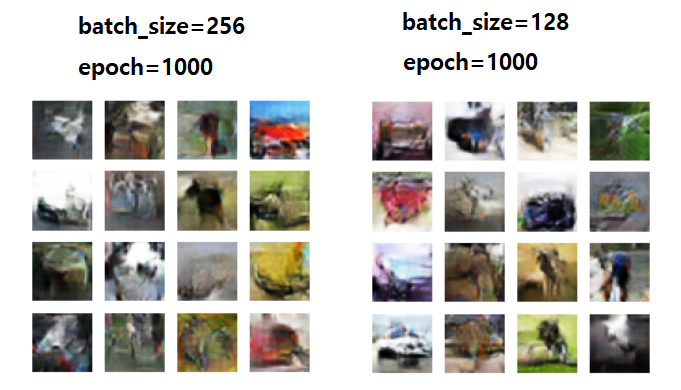
- 같은 epoch으로 비교를 해보니 확실히 batch_size=128의 이미지가 좀 더 선명해 보이는 건 나의 착각인가??
- 이제 그만해야지... ㅎㅎ

## 회고

- 이번 과제는 좀 놀랍기는 하다. 무에서 유를 창조하는 것이 대단하게 느껴진다.   
- 다른 과제와는 달리 판별할 수 있는 기준이 좀 애매하기는 하다..
- loss, accuracy보다는 인간의 눈으로 판단한다고 하니..
- 노드에 적혀있던 문구가 계속 맘에 걸려서.. 둘다 1인 것은 좋지 않다...둘다 accuracy가 0.5로 가는 것이 좋다고 하는 데..
  결과는 그렇지 못한 거 같다..
  
#### 배운 것 
- 무에서 유를 창조..
- accuracy만이 판별기준은 아니다.
- hist의 gif는 구연님이 도움을 주셨다.. 😍😍

####  아쉬운 것
- 시간이 좀 더 된다면 더 많은 시간을 투자해 좀 더 선명한 이미지를 보고싶다...
- 랜덤시드를 정해서 같은 이미지로 비교를 못한 것이 아쉽다...

#### 애매한 것
- 아직도 accuracy가 애매하다..
